# imports

In [1]:
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

In [2]:
from copy import deepcopy
from datetime import datetime
from typing import Annotated, Dict, List, Literal, Optional, TypedDict, Callable

from catppuccin.extras.rich_ctp import mocha

from rich import pretty
from rich.console import Console
from rich.pretty import pprint

from src.config.settings import get_settings
from src.utils.logger import ChatPrinter, create_logger

console = Console(theme=mocha)
settings = get_settings()
logger = create_logger(path=settings.paths.logs_dir)
printer = ChatPrinter()
logger.debug(f"settings loaded as \n{settings.model_dump_json(indent=2)}")

pretty.install()

08:20 PM | 4152606671.L:18  | DEBUG     | settings loaded as 
{
  "models": {
    "hf": {
      "chat": "meta-llama/Llama-3.2-3B-Instruct:together",
      "reasoning": "zai-org/GLM-4.7-Flash:novita",
      "structured_output": "Qwen/Qwen3-Coder-30B-A3B-Instruct:ovhcloud",
      "embedding_snowflake": "Snowflake/snowflake-arctic-embed-l-v2.0",
      "embedding_specter": "allenai/specter2_base",
      "encoder": "m3rg-iitd/matscibert",
      "reranker": "Qwen/Qwen3-Reranker-0.6B",
      "router": "openai/gpt-oss-20b:together"
    },
    "nebius": {
      "reasoning": "deepseek-ai/DeepSeek-V3.2",
      "tool_user": "Qwen/Qwen3-30B-A3B-Instruct-2507",
      "chat": "meta-llama/Meta-Llama-3.1-8B-Instruct-fast",
      "embedding_baai_bge": "BAAI/bge-multilingual-gemma2",
      "router": "openai/gpt-oss-20b"
    }
  },
  "paths": {
    "base_dir": "C:\\Users\\70086503\\code\\lattice\\src",
    "data_dir": "C:\\Users\\70086503\\code\\lattice\\src\\data",
    "logs_dir": "C:\\Users\\70086503\\c

In [3]:
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    HumanMessage,
    MessageLikeRepresentation,
    SystemMessage,
    ToolMessage,
    convert_to_openai_messages,
    filter_messages,
    get_buffer_string,
)
from langchain_core.runnables import RunnableConfig

from langchain_core.tools import StructuredTool, tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_nebius import ChatNebius
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.runtime import Runtime
from langgraph.types import Command, Overwrite, interrupt
from pydantic import BaseModel, Field, create_model
from pydantic.json_schema import SkipJsonSchema

from deepagents.middleware import FilesystemMiddleware, SummarizationMiddleware

In [4]:
from src.prompts import (
    ask_mode_system_prompt,
    planning_mode_system_prompt,
    planning_structured_output,
)
from src.schemas import (
    RESEARCH_PLAN_TEMPLATE,
    ResearchPlan,
    SystemPromptTemplate,
)
from src.tools import (
    switch_to_ask_mode_tool,
    switch_to_execution_mode_tool,
    switch_to_planning_mode_tool,
    think_tool,
    SkipSchema,
    wrap_tool_with_doc_and_error_handling,
    filter_tool_from_middleware_by_name,
    USAGE_INSTRUCTIONS,
)
from src.utils.stats import accumulate_usage, add_usage_metadata
from src.backends import CustomBackend

version = "0.0.1-alpha"

# load file system backend

also need to filter tools

In [ ]:
tool_param_descriptions = {
    "ls": {"path": "Absolute path to the directory to list. Must start with '/'. "},
    "read_file": {
        "file_path": "Absolute path to the file to read. Must start with '/'",
        "offset": "Line number to start reading from (0-indexed). Default: 0.",
        "limit": "Maximum number of lines to read. Default: 2000.",
    },
    "write_file": {
        "file_path": "Absolute path where the file should be created. Must start with '/'.",
        "content": "String content to write to the file.",
    },
    "edit_file": {
        "file_path": "Absolute path to the file to edit. Must start with '/'.",
        "old_string": "Exact string to search for and replace. Must match exactly including whitespace and indentation.",
        "new_content": "String to replace old_string with. Must be different from old_string.",
        "replace_all": "If True, replace all occurrences. If False (default), old_string must be unique in the file or the edit fails.",
    },
    "glob": {
        "pattern": "Glob pattern to match files against (e.g., `'*.py'`, `'**/*.txt'`).",
        "path": "Base directory to search from. Defaults to root (`/`).",
    },
    "grep": {
        "pattern": ' Literal string to search for (NOT regex). Performs exact substring matching within file content. Example: "TODO" matches any line containing "TODO", but not "TODOS" or "TO DO".',
        "path": 'Optional directory path to search in. If None, searches in current working directory. Example: "/workspace/src".',
        "glob": """Optional glob pattern to filter which FILES to search.
Filters by filename/path, not content.
Supports standard glob wildcards:
- `*` matches any characters in filename
- `**` matches any directories recursively
- `?` matches single character
- `[abc]` matches one character from set""",
        "output_mode": """Specifies format of grep output. Options:
- file_with_matches: file paths only, default
- content: matching lines with content
- count: match counts per file""",
    },
}
backend = CustomBackend()

# so for the ask node
# it will have access to only the ls and read_file tools
ask_filesystem_mw = FilesystemMiddleware(backend=backend)
for i in range(len(ask_filesystem_mw.tools)):
    ask_filesystem_mw.tools[i].args_schema = wrap_tool_with_doc_and_error_handling(
        ask_filesystem_mw.tools[i].func,
        custom_name=ask_filesystem_mw.tools[i].name,
        custom_description=ask_filesystem_mw.tools[i].description,
        custom_param_descriptions=tool_param_descriptions.get(
            ask_filesystem_mw.tools[i].name, {}
        ),
    ).args_schema
ask_filesystem_mw = filter_tool_from_middleware_by_name(
    ask_filesystem_mw, include=["ls", "read_file"]
)

# the planning node and execution node will have access to all the tools
filesystem_mw = FilesystemMiddleware(backend=backend)
for i in range(len(filesystem_mw.tools)):
    filesystem_mw.tools[i].args_schema = wrap_tool_with_doc_and_error_handling(
        filesystem_mw.tools[i].func,
        custom_name=filesystem_mw.tools[i].name,
        custom_description=filesystem_mw.tools[i].description,
        custom_param_descriptions=tool_param_descriptions.get(
            filesystem_mw.tools[i].name, {}
        ),
    ).args_schema
filesystem_mw = filter_tool_from_middleware_by_name(
    filesystem_mw,
    include=["ls", "read_file", "write_file"],
)

In [6]:
from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse

## prompts

In [ ]:
ask_mode_system_prompt.workflow = """Given a user query, broadly follow the below steps:
1. Judge if the query is complex. 
    a. Look at the conversation history to understand if the current context of the conversation is complex or straightforward.
    b. Straightforward queries are usually like:
        - small talk (eg: "how are you?", "how can you help me?" etc)
        - basic questions (eg: simple arithmetic, questions about universal facts etc)
2. if the query is deemed to be straightforward, then answer the question directly.
3. if the query is deemed complex, 
    a. use the `think_tool` to think and reflect. 
    b. for each thought, make a single call for `think_tool`
    c. if you think you need some input from the user, do not use any tool and just send your response.
    d. if you are unsure about anything, just ask the user.
    e. based on new user input evaluate the current conversation context and proceed from step 2.
4. once you deem the user has presented you with a query asking for help with their research literature survey and you have fulfilled all criteria to use the `switch_to_planning_mode_tool`, use it and proceed to the next mode.
"""
ask_mode_system_prompt.filesystem = """
You have access to a Virtual Sandboxed Filesystem with the following paths:
- /notes/ : This directory is for your personal notes. These are things like:
    * information you have gathered about the user's research topic
    * quick notes you have taken while thinking and reflecting with the `think_tool`
- /memories/ : You can store things that you wish to remember (hence "memories") here. These are things like:
    * long term user preferences
    * important past interactions
    * user-specific knowledge

Things to remember about interacting with the filesystem:
- You will have access to some filesystem tools to interact with the filesystem. More details below.
- Always use absolute paths starting with '/' when interacting with the filesystem.
- You cannot create subdirectories in either /notes/ or /memories/.
- When you write files, make sure to give them descriptive names so that you can easily find them later. 
- Files must be written in valid markdown format.
"""

In [8]:
import json

In [32]:
@wrap_model_call
def ask_node(
    request: ModelRequest, handler: Callable[[ModelRequest], ModelResponse]
) -> ModelResponse:
    # get information from the request
    state = request.state
    tools = request.tools
    tool_choice = request.tool_choice
    llm = request.model
    # we need to serve the context to the ask node
    # it contains
    # - system prompt
    # - all non tool messages messages with non-empty content
    # - all tool messages except the ones from `think_tool`
    # - thoughts
    ask_mode_system_prompt.tools = (
        "You have access to the following tools\n"
        + "\n".join(
            [
                f"- `{tool.name}` - {USAGE_INSTRUCTIONS[tool.name].get('desc', '')}"
                for tool in tools
            ]
        )
    )
    system_prompt = [SystemMessage(ask_mode_system_prompt.to_markdown())]
    messages = [
        _
        for _ in state["messages"]
        if (len(_.content) > 0 and not isinstance(_, ToolMessage))
        or (isinstance(_, ToolMessage) and _.name != "think_tool")
    ]
    # thoughts are recorded in tool messages
    # response is recieved as "Reflection recorded: {thought}" from the think_tool, so we need to extract the actual thought from the response
    thoughts = [
        _.content[21:]
        for _ in state["messages"]
        if isinstance(_, ToolMessage) and _.name == "think_tool"
    ]
    if thoughts:
        thoughts = [
            SystemMessage(
                "Your thoughts so far are given next: \n"
                + "\n".join([f"{i}. {t}" for i, t in enumerate(thoughts, 1)])
            )
        ]
    full_context = system_prompt + messages + thoughts
    bound_llm = llm.bind_tools(
        tools=tools,
        strict=True,
        parallel_tool_calls=False,
    )
    response = bound_llm.invoke(full_context)
    # logger.debug(response)
    if response.tool_calls:
        for tool_call in response.tool_calls:
            if tool_call["name"] == "switch_to_planning_mode_tool":
                overridden_messages = [
                    _
                    for _ in state["messages"]
                    if not (isinstance(_, ToolMessage) and _.name == "think_tool")
                ]
                return Command(
                    update={"messages": Overwrite(overridden_messages)}, goto=END
                )
    return ModelResponse(result=response)

In [33]:
from langchain_openai import ChatOpenAI

In [34]:
from langchain.agents import create_agent

In [35]:
class AgentState(MessagesState):
    thoughts: list

In [36]:
checkpointer = MemorySaver()

In [37]:
agent = create_agent(
    model=ChatNebius(
        model=settings.models.nebius.tool_user,
        api_key=settings.env.NEBIUS_API_KEY,
        temperature=0,
        base_url=settings.env.NEBIUS_API_ENDPOINT,
        model_kwargs={
            "extra_body": {"trust-request-chat-template": True},
        },
    ),
    system_prompt="",
    middleware=[ask_node, ask_filesystem_mw],
    tools=[think_tool, switch_to_planning_mode_tool],
    state_schema=AgentState,
    checkpointer=checkpointer,
)

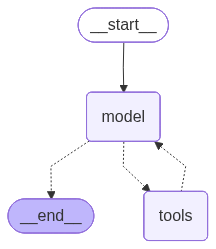

In [38]:
agent

In [39]:
config = {"configurable": {"thread_id": "thread-3"}}

In [40]:
state = agent.get_state(config)

In [41]:
while True:
    human = input()
    response = agent.invoke({"messages": [HumanMessage(human)]}, config=config)
    for msg in response["messages"]:
        msg.pretty_print()

================================ Human Message =================================

help me do an introductory survey on RL post training methods for SLM's
None
================================== Ai Message ==================================

I'm ready to help you with an introductory survey on reinforcement learning (RL) post-training methods for small language models (SLMs). To get started, could you please clarify the following:

1. What specific aspects of RL post-training methods for SLMs are you most interested in? (e.g., reward modeling, preference learning, fine-tuning strategies, scalability challenges, evaluation metrics)
2. Are you focusing on any particular application domain (e.g., dialogue systems, code generation, summarization)?
3. Do you have a preferred scope for the survey—broad overview, technical depth, or comparison of key methods?

This will help me tailor the survey to your needs.
None
================================ Human Message ================================

AttributeError: 'Command' object has no attribute 'result'

In [19]:
import os

In [20]:
os.listdir(backend.memories_fs.getsyspath("/"))

[]

In [21]:
backend.memories_fs.getsyspath("/")

'C:\\Users\\70086503\\AppData\\Local\\Temp\\tmpm77ptk7dmemories\\'